# AG News Classification

### Install Necessary libraries

In [1]:
!pip install gensim
!pip install wordcloud
!pip install sentence-transformers
!pip install nlpaug
!pip install transformers

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import torch
import nltk
import re
import warnings
import string as s

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB 

import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import StandardScaler
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

warnings.filterwarnings("ignore")

### Load the Dataset

In [3]:
train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0, names=['ID', 'Title', 'Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0, names=['ID', 'Title', 'Desc'])

train_data = train_data.groupby('ID').apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)
test_data = test_data.groupby('ID').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Training set shape: (20000, 3)
Test set shape: (4000, 3)


#### Let's Have a look into our dataset

In [4]:
train_data.head()

,ID,Title,Desc
0,1,Explosion Rocks Baghdad Neighborhood,"BAGHDAD, Iraq, August 24 -- A car bomb explode..."
1,1,BBC reporters' log,BBC correspondents record events in the Middle...
2,1,Israel welcomes Rice nomination; Palestinians ...,Israel on Tuesday warmly welcomed the naming o...
3,1,Medical Journal Calls for a New Drug Watchdog,Medical researchers said the U.S. needs a syst...
4,1,Militants Kidnap Relatives of Iraqi Minister-TV,Militants have kidnapped two relatives of Iraq...


In [5]:
test_data.head()

,ID,Title,Desc
0,1,Large Explosion Heard in Central Baghdad (Reut...,Reuters - A large blast was heard in central\B...
1,1,Israel OKs More West Bank Settlement Homes,"JERUSALEM Aug. 23, 2004 - Israel announced pla..."
2,1,Scores of Iraqis die in 3 days of attacks,US troops fought a gunbattle with insurgents a...
3,1,At least 20 dead in Kurkik bombing,A suicide attacker detonated a car bomb near a...
4,1,"Israel, Egypt in Prisoner Swap",CAIRO (Reuters) - Israel released six Egyptia...


#### Check the Shape

In [6]:
print(train_data.shape)
print(test_data.shape)

(20000, 3)
(4000, 3)


## Data Analysis

### Plot the count of each category

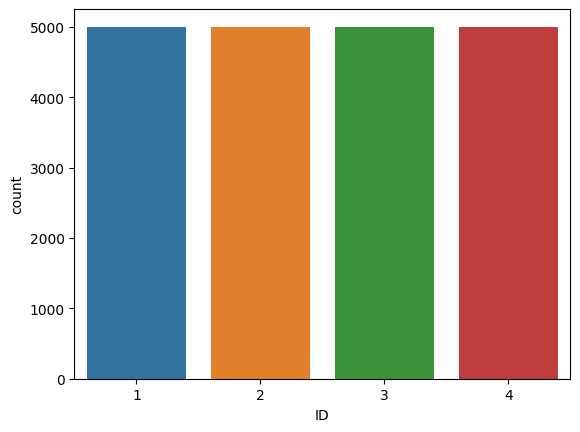

In [7]:
sns.countplot(x = 'ID', data = train_data)
plt.show()

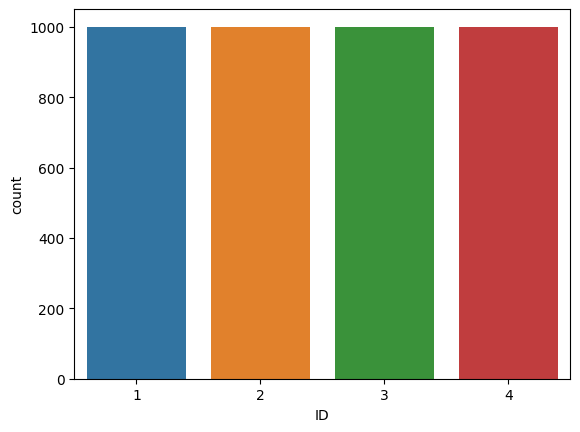

In [8]:
sns.countplot(x = 'ID', data = test_data)
plt.show()

#### Let's get our data for preprocessing

In [9]:
train_x = train_data.Desc
test_x = test_data.Desc
train_y = train_data.ID
test_y = test_data.ID

### Visualize most frequent terms in our dataset for each category

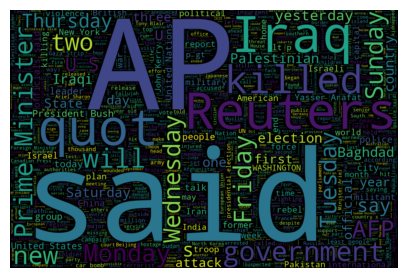

In [10]:
world = train_data[train_data['ID'] == 1]['Desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

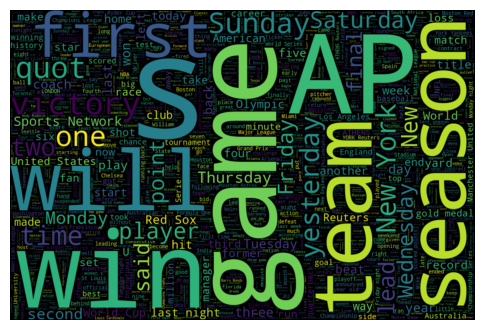

In [11]:
sports_desc = train_data.loc[train_data['ID'] == 2, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

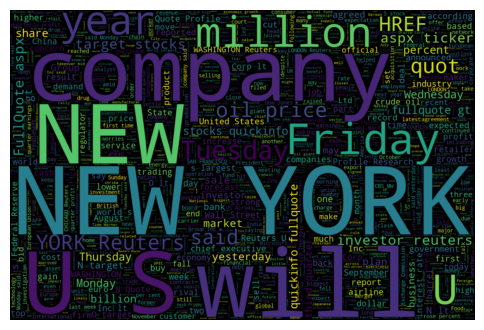

In [12]:
biz_desc = train_data.loc[train_data['ID'] == 3, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

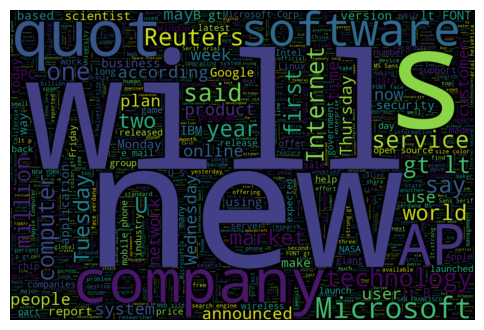

In [13]:
sci_desc = train_data.loc[train_data['ID'] == 4, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Preprocessing


### Html tag Removal using regex

In [14]:
def remove_html_tag(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text
train_x = train_x.apply(remove_html_tag)
test_x = test_x.apply(remove_html_tag)

train_x_sbert = train_x.apply(remove_html_tag)
test_x_sbert = test_x.apply(remove_html_tag)

### let's remove the url's

In [15]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)

train_x_sbert = train_x_sbert.apply(url_remove)
test_x_sbert = test_x_sbert.apply(url_remove)

### Splitting text into tokens

In [16]:
def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

### Lower casing all the tokens

In [17]:
train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

### Stopword Removal

In [18]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

### Removing Punctuations

In [19]:
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)

### Remove the occurence of any numbers from documents

In [20]:
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]

train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

### Get the words to their original(root) form via stemming 

In [21]:
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

### Removal of Custom Stopwords

In [22]:
def remove_extra_words(word_list):
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in stopwords:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(remove_extra_words)
test_x = test_x.apply(remove_extra_words)

### Form Sentence out of processed tokens

In [23]:
def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)

## Embeddings

### Function to apply TF-IDF embeddings

In [24]:
def apply_tfidf_embeddings(train_x, test_x):
    tfidf = TfidfVectorizer(max_features=5000)
    train_tfidf = tfidf.fit_transform(train_x)
    test_tfidf = tfidf.transform(test_x)
    
    return train_tfidf, test_tfidf

### Function to apply SBERT embeddings

In [25]:
def apply_sbert_embeddings(train_x, test_x):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    train_sbert = model.encode(train_x.tolist(), convert_to_tensor=True)
    test_sbert = model.encode(test_x.tolist(), convert_to_tensor=True)
    
    return train_sbert, test_sbert

### Function to apply doc2vec embeddings

In [26]:
def apply_doc2vec_embeddings(train_x, test_x):
    train_documents = [TaggedDocument(words=sentence.split(), tags=[str(i)]) for i, sentence in enumerate(train_x)]
    test_documents = [TaggedDocument(words=sentence.split(), tags=[str(i)]) for i, sentence in enumerate(test_x)]
    
    model = Doc2Vec(vector_size=300, window=2, min_count=1, workers=4, epochs=40)
    model.build_vocab(train_documents)
    model.train(train_documents, total_examples=model.corpus_count, epochs=model.epochs)
    
    train_doc2vec = [model.infer_vector(sentence.words) for sentence in train_documents]
    test_doc2vec = [model.infer_vector(sentence.words) for sentence in test_documents]
    
    return train_doc2vec, test_doc2vec

### Function to apply Word2Vec embeddings

In [27]:
def apply_word2vec_embeddings(train_x, test_x):
    sentences_train = [sentence.split() for sentence in train_x]
    sentences_test = [sentence.split() for sentence in test_x]
    
    model = Word2Vec(sentences_train, vector_size=300, window=5, min_count=1, workers=4)
    model.save("word2vec.model")
    
    def get_average_word2vec(sentence):
        words = sentence.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

    train_word2vec = np.array([get_average_word2vec(sentence) for sentence in train_x])
    test_word2vec = np.array([get_average_word2vec(sentence) for sentence in test_x])
    
    return train_word2vec, test_word2vec

#### Define class names in their corresponding index

In [28]:
class_names = ["World", "Sports", "Business", "Science/Tech"]  # Example classes

### Function to evaluate Model's Performance

In [29]:
def evaluate_model(model, embeddings_test, test_y):
    # Make predictions on the test set
    y_pred = model.predict(embeddings_test)
    # Print accuracy
    print(f"Accuracy is: {accuracy_score(test_y, y_pred)}")
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(test_y, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(test_y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap="Greens", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # Print misclassified examples
    misclassified_indices = np.where(y_pred != test_y)[0]
    print("Misclassified Texts:")
    for idx in misclassified_indices[:5]:  
        predicted_class = int(y_pred[idx])
        actual_class = int(test_y[idx])
        
        # Print predicted and actual class names from the mapping
        print(f"Predicted: {class_names[predicted_class]}, Actual: {class_names[actual_class]}")
        print(f"Text: {test_x.iloc[idx]}")
        print("-" * 50)

### Apply all the embeddings using previously defined functions

In [30]:
train_tfidf, test_tfidf = apply_tfidf_embeddings(train_x, test_x)
train_sbert, test_sbert = apply_sbert_embeddings(train_x_sbert, test_x_sbert)
train_doc2vec, test_doc2vec = apply_doc2vec_embeddings(train_x, test_x)
train_word2vec, test_word2vec = apply_word2vec_embeddings(train_x, test_x)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

#### Put the SBERT embeddings back to CPU if not already in CPU.

In [31]:
# Check if test_sbert is a CUDA tensor (on GPU)
if isinstance(test_sbert, torch.Tensor) or isinstance(train_sbert, torch.Tensor):
    # Move the tensor to CPU and detach it before converting to numpy
    train_sbert = train_sbert.to('cpu').detach().numpy()
    test_sbert = test_sbert.to('cpu').detach().numpy()

#### Convert doc2vec embeddings to numpy array

In [32]:
train_doc2vec = np.array(train_doc2vec)
test_doc2vec = np.array(test_doc2vec)

### Function to scale all the embeddings

In [33]:
# Function to apply standard scaling
def apply_standard_scaler(train_data, test_data):
    scaler = StandardScaler(with_mean=False)
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled

### Apply standard scaling to each embedding variable


In [34]:
train_tfidf, test_tfidf = apply_standard_scaler(train_tfidf, test_tfidf)
train_sbert, test_sbert = apply_standard_scaler(train_sbert, test_sbert)
train_doc2vec, test_doc2vec = apply_standard_scaler(train_doc2vec, test_doc2vec)
train_word2vec, test_word2vec = apply_standard_scaler(train_word2vec, test_word2vec)

### Label Encode the Features for Training and Initialize KFolds

In [35]:
label_encoder = LabelEncoder()

train_y = label_encoder.fit_transform(train_y)
test_y = label_encoder.transform(test_y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Modelling


### Initialize all the Models

In [36]:
xgb_model = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor")

rf_model = RandomForestClassifier()


catboost_model = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    task_type="GPU",  
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=[],
    verbose=0
)


voting_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('catboost', catboost_model)],
    voting='soft'  
)

## Experiments


### Experiment-1 Applying XGBoost, RandomForest, CatBoost and Voting Classifier to asses the Models on Word2Vec Embeddings

#### XGBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9994
Training F1 Score: 0.9994

Validation Accuracy: 0.7378
 Validation F1 Score: 0.7368
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9995
Training F1 Score: 0.9995

Validation Accuracy: 0.7432
 Validation F1 Score: 0.7418
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9994
Training F1 Score: 0.9994

Validation Accuracy: 0.7410
 Validation F1 Score: 0.7398
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9994
Training F1 Score: 0.9994

Validation Accuracy: 0.7402
 Validation F1 Score: 0.7385
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9996
Training F1 Score: 0.9996

Validation Accuracy: 0.7408
 Validation F1 Score: 0.7396
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9994
Training F1 Score: 0.9994

Validation Accuracy: 0.7378
 Validation F1 Score: 0.7368
-----

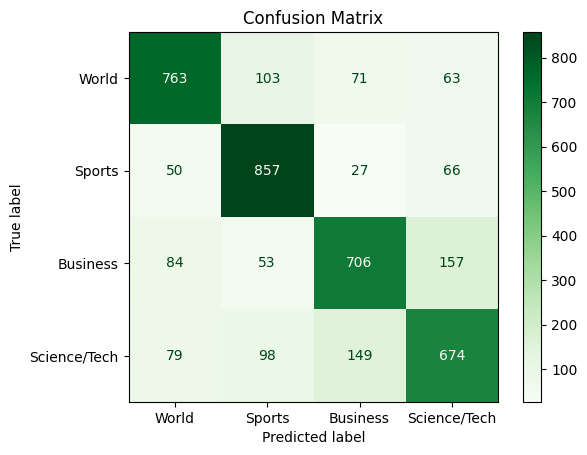

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: dup leader ian paisley discuss head independ decommiss bodi iicd issu put ira weapon beyond use
--------------------------------------------------
Predicted: Sports, Actual: World
Text: islamabad nov  nnn pakistan lead newspap dawn find time indian announc reduct troop kashmir signific
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin 

In [37]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_word2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        xgb_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = xgb_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = xgb_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_word2vec, test_y)

#### RandomForest

Iteration: 1
Fold 1/5
Training Accuracy: 0.9997
Training F1 Score: 0.9997

Validation Accuracy: 0.7135
 Validation F1 Score: 0.7113
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9996
Training F1 Score: 0.9996

Validation Accuracy: 0.7173
 Validation F1 Score: 0.7151
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9997
Training F1 Score: 0.9997

Validation Accuracy: 0.7200
 Validation F1 Score: 0.7179
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9996
Training F1 Score: 0.9996

Validation Accuracy: 0.7242
 Validation F1 Score: 0.7213
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9995
Training F1 Score: 0.9995

Validation Accuracy: 0.7202
 Validation F1 Score: 0.7182
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9997
Training F1 Score: 0.9997

Validation Accuracy: 0.7222
 Validation F1 Score: 0.7202
-----

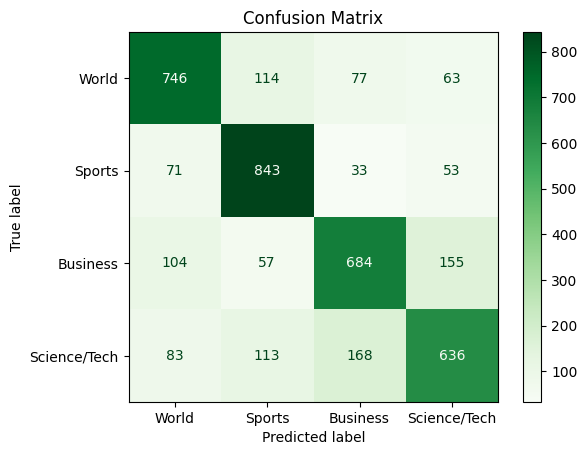

Misclassified Texts:
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Sports, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: dup leader ian paisley discuss head independ decommiss bodi iicd issu put ira weapon beyond use
--------------------------------------------------
Predicted: Sports, Actual: World
Text: dup last night reconsid boycott talk irish govern taoiseach berti ahern apologis parti leader ian paisley
--------------------------------------------------
Predicted: Sports, Actual: World
Text: islamabad nov  nnn pakistan lead newspap dawn find time indian announc reduct troop kashmir signif

In [38]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_word2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        rf_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = rf_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = rf_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_word2vec, test_y)

#### CatBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9329
Training F1 Score: 0.9328

Validation Accuracy: 0.7368
 Validation F1 Score: 0.7353
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9318
Training F1 Score: 0.9317

Validation Accuracy: 0.7428
 Validation F1 Score: 0.7412
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9331
Training F1 Score: 0.9330

Validation Accuracy: 0.7470
 Validation F1 Score: 0.7454
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9327
Training F1 Score: 0.9326

Validation Accuracy: 0.7490
 Validation F1 Score: 0.7471
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9332
Training F1 Score: 0.9331

Validation Accuracy: 0.7412
 Validation F1 Score: 0.7399
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9329
Training F1 Score: 0.9328

Validation Accuracy: 0.7368
 Validation F1 Score: 0.7353
-----

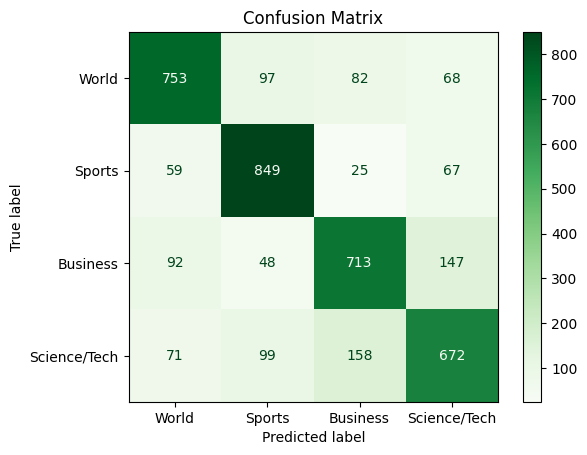

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [39]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_word2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        catboost_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = catboost_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = catboost_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_word2vec, test_y)

#### Voting Classifier

Iteration: 1
Fold 1/5
Training Accuracy: 0.9981
Training F1 Score: 0.9981

Validation Accuracy: 0.7420
 Validation F1 Score: 0.7407
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9973
Training F1 Score: 0.9973

Validation Accuracy: 0.7445
 Validation F1 Score: 0.7429
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9974
Training F1 Score: 0.9974

Validation Accuracy: 0.7535
 Validation F1 Score: 0.7522
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9982
Training F1 Score: 0.9983

Validation Accuracy: 0.7458
 Validation F1 Score: 0.7437
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9978
Training F1 Score: 0.9978

Validation Accuracy: 0.7460
 Validation F1 Score: 0.7446
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9979
Training F1 Score: 0.9979

Validation Accuracy: 0.7420
 Validation F1 Score: 0.7409
-----

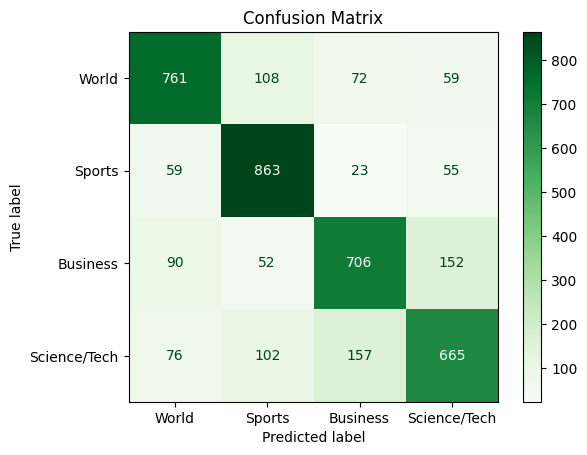

Misclassified Texts:
Predicted: Business, Actual: World
Text: jerusalem aug   israel announc plan monday build hundr new hous unit west bank follow appar us polici shift settlement palestinian warn destroy peac process
--------------------------------------------------
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: dup leader ian paisley discuss head independ decommiss bodi iicd issu put ira weapon beyond use
--------------------------------------------------
Predicted: Sports, Actual: World
Text: islamabad nov  nnn pakistan lead newspap dawn find time india

In [40]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_word2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_word2vec[train_index], train_word2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        voting_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = voting_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = voting_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(voting_model, test_word2vec, test_y)

### Experiment-2 Applying XGBoost, RandomForest, CatBoost and Voting Classifier to asses the Models on TF-IDF Embeddings

#### XGBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.4501
Training F1 Score: 0.4265

Validation Accuracy: 0.4240
 Validation F1 Score: 0.3970
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.4168
Training F1 Score: 0.3801

Validation Accuracy: 0.4095
 Validation F1 Score: 0.3715
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.4376
Training F1 Score: 0.4184

Validation Accuracy: 0.4333
 Validation F1 Score: 0.4137
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.4557
Training F1 Score: 0.4321

Validation Accuracy: 0.4550
 Validation F1 Score: 0.4326
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.4267
Training F1 Score: 0.3952

Validation Accuracy: 0.4358
 Validation F1 Score: 0.4014
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.4501
Training F1 Score: 0.4265

Validation Accuracy: 0.4240
 Validation F1 Score: 0.3970
-----

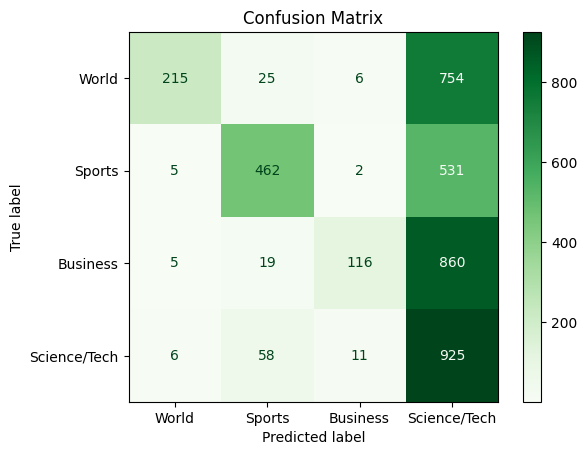

Misclassified Texts:
Predicted: Science/Tech, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: jerusalem aug   israel announc plan monday build hundr new hous unit west bank follow appar us polici shift settlement palestinian warn destroy peac process
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: cairo reuter israel releas six egyptian student prison sunday part deal includ freedom isra businessman convict spi azzam azzam egyptian secur sourc said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel hel

In [41]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_tfidf), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        xgb_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = xgb_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = xgb_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_tfidf, test_y)

#### RandomForest

Iteration: 1
Fold 1/5
Training Accuracy: 0.9997
Training F1 Score: 0.9997

Validation Accuracy: 0.8498
 Validation F1 Score: 0.8493
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9996
Training F1 Score: 0.9996

Validation Accuracy: 0.8413
 Validation F1 Score: 0.8403
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9997
Training F1 Score: 0.9997

Validation Accuracy: 0.8462
 Validation F1 Score: 0.8453
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9996
Training F1 Score: 0.9996

Validation Accuracy: 0.8448
 Validation F1 Score: 0.8437
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9996
Training F1 Score: 0.9996

Validation Accuracy: 0.8430
 Validation F1 Score: 0.8420
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9997
Training F1 Score: 0.9997

Validation Accuracy: 0.8442
 Validation F1 Score: 0.8438
-----

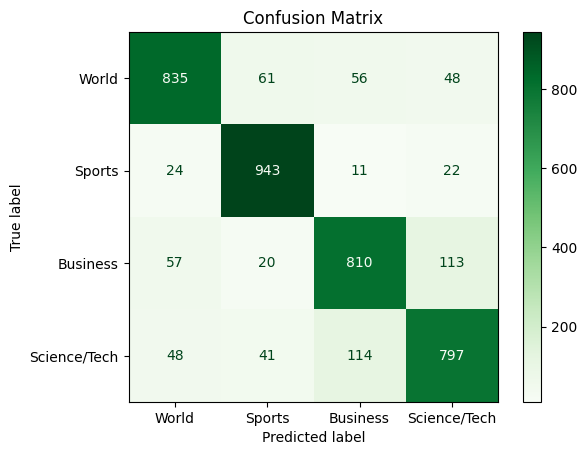

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Sports, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord 

In [42]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_tfidf), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        rf_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = rf_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = rf_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_tfidf, test_y)

#### CatBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9034
Training F1 Score: 0.9029

Validation Accuracy: 0.8682
 Validation F1 Score: 0.8676
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9048
Training F1 Score: 0.9044

Validation Accuracy: 0.8590
 Validation F1 Score: 0.8583
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9023
Training F1 Score: 0.9019

Validation Accuracy: 0.8612
 Validation F1 Score: 0.8604
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9028
Training F1 Score: 0.9024

Validation Accuracy: 0.8615
 Validation F1 Score: 0.8605
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9039
Training F1 Score: 0.9035

Validation Accuracy: 0.8625
 Validation F1 Score: 0.8617
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9034
Training F1 Score: 0.9029

Validation Accuracy: 0.8682
 Validation F1 Score: 0.8676
-----

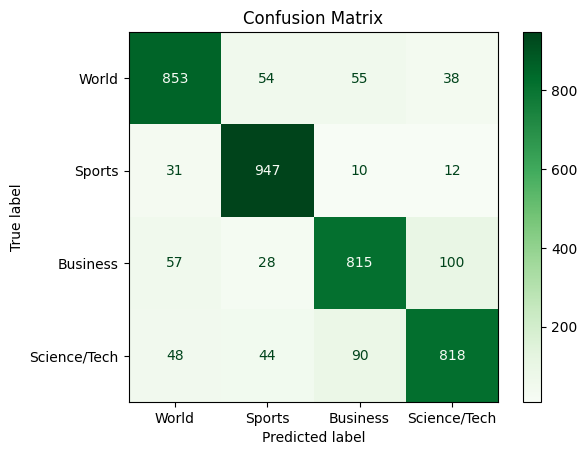

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [43]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_tfidf), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        catboost_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = catboost_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = catboost_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_tfidf, test_y)

#### Voting Classifier

Iteration: 1
Fold 1/5
Training Accuracy: 0.9705
Training F1 Score: 0.9705

Validation Accuracy: 0.8592
 Validation F1 Score: 0.8588
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9706
Training F1 Score: 0.9705

Validation Accuracy: 0.8532
 Validation F1 Score: 0.8526
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9706
Training F1 Score: 0.9705

Validation Accuracy: 0.8565
 Validation F1 Score: 0.8559
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9712
Training F1 Score: 0.9711

Validation Accuracy: 0.8555
 Validation F1 Score: 0.8547
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9699
Training F1 Score: 0.9698

Validation Accuracy: 0.8528
 Validation F1 Score: 0.8519
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9716
Training F1 Score: 0.9716

Validation Accuracy: 0.8552
 Validation F1 Score: 0.8549
-----

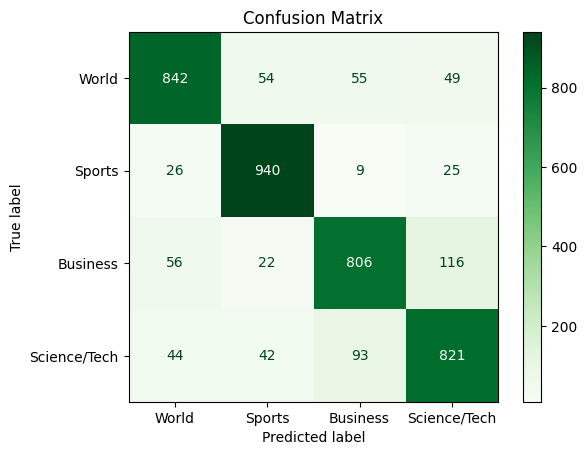

Misclassified Texts:
Predicted: Sports, Actual: World
Text: mep threaten last night bring new european commiss even take offic row spark controversi comment homosexu escal unpreced crisi
--------------------------------------------------
Predicted: Sports, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord 

In [44]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_tfidf), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_tfidf[train_index], train_tfidf[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        voting_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = voting_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = voting_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(voting_model, test_tfidf, test_y)

### Experiment-3 Applying XGBoost, RandomForest, CatBoost and Voting Classifier to asses the Models on SBERT Embeddings

#### XGBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8645
 Validation F1 Score: 0.8645
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8628
 Validation F1 Score: 0.8627
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.8635
 Validation F1 Score: 0.8634
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.8648
 Validation F1 Score: 0.8645
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8668
 Validation F1 Score: 0.8666
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8645
 Validation F1 Score: 0.8645
-----

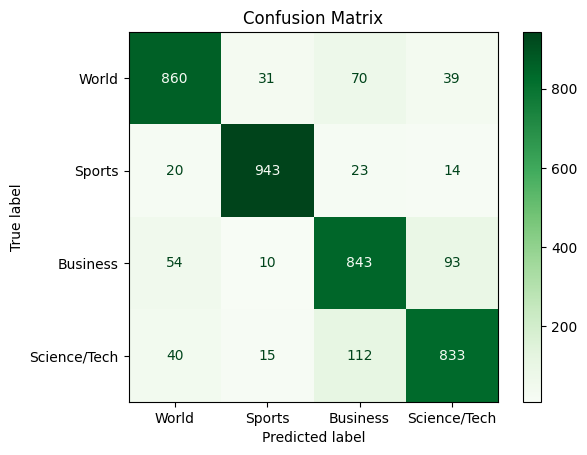

Misclassified Texts:
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord reach alitalia manag staff major restructur plan aim keep struggl airlin air
--------------------------------------------------
Predicted: Sports, Actual: World
Text: sachin tendulkar almost certain miss thursday second test australia madra
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: reuter piec britain past includ second centuri silver ring  year old tudor trade weight among

In [45]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_sbert), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_sbert[train_index], train_sbert[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        xgb_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = xgb_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = xgb_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_sbert, test_y)

#### RandomForest

Iteration: 1
Fold 1/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8495
 Validation F1 Score: 0.8492
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8468
 Validation F1 Score: 0.8466
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.8475
 Validation F1 Score: 0.8469
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.8438
 Validation F1 Score: 0.8430
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8540
 Validation F1 Score: 0.8536
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8520
 Validation F1 Score: 0.8516
-----

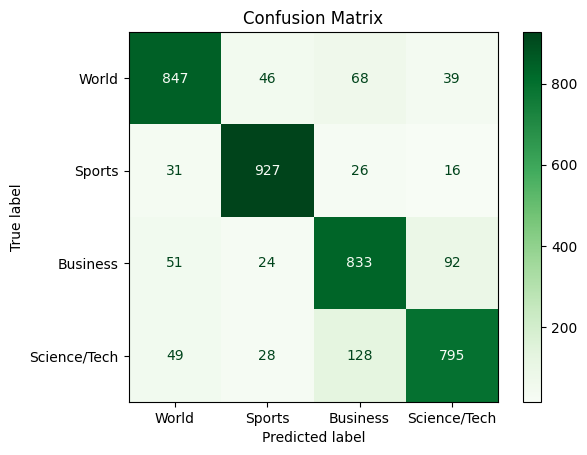

Misclassified Texts:
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Business, Actual: World
Text: thousand disgruntl vacation strand heathrow airport tuesday british airway cancel score flight staff shortag technic hitch
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord reach alitalia manag staff major restructur plan aim keep struggl airlin air
--------------------------------------------------
Predicted: Sports, Actual: World
Text: sachin tendulkar almos

In [46]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_sbert), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_sbert[train_index], train_sbert[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        rf_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = rf_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = rf_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_sbert, test_y)

#### CatBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9706
Training F1 Score: 0.9706

Validation Accuracy: 0.8698
 Validation F1 Score: 0.8696
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9718
Training F1 Score: 0.9718

Validation Accuracy: 0.8642
 Validation F1 Score: 0.8640
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9722
Training F1 Score: 0.9722

Validation Accuracy: 0.8698
 Validation F1 Score: 0.8695
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9736
Training F1 Score: 0.9736

Validation Accuracy: 0.8692
 Validation F1 Score: 0.8689
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9735
Training F1 Score: 0.9735

Validation Accuracy: 0.8702
 Validation F1 Score: 0.8701
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9706
Training F1 Score: 0.9706

Validation Accuracy: 0.8698
 Validation F1 Score: 0.8696
-----

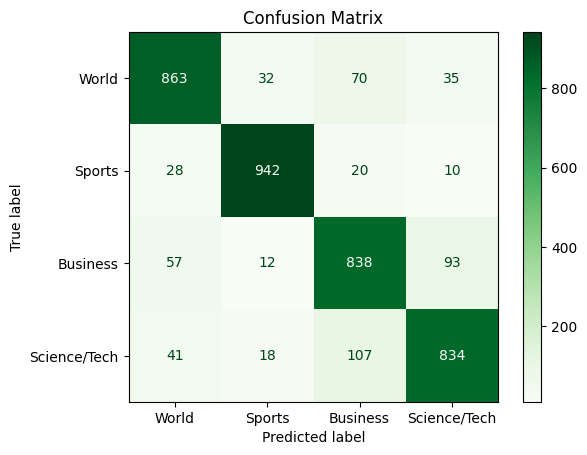

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [47]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_sbert), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_sbert[train_index], train_sbert[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        catboost_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = catboost_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = catboost_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_sbert, test_y)

#### Voting Classifier

Iteration: 1
Fold 1/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8718
 Validation F1 Score: 0.8716
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8690
 Validation F1 Score: 0.8688
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.8715
 Validation F1 Score: 0.8713
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.8740
 Validation F1 Score: 0.8738
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8728
 Validation F1 Score: 0.8726
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9998
Training F1 Score: 0.9998

Validation Accuracy: 0.8730
 Validation F1 Score: 0.8729
-----

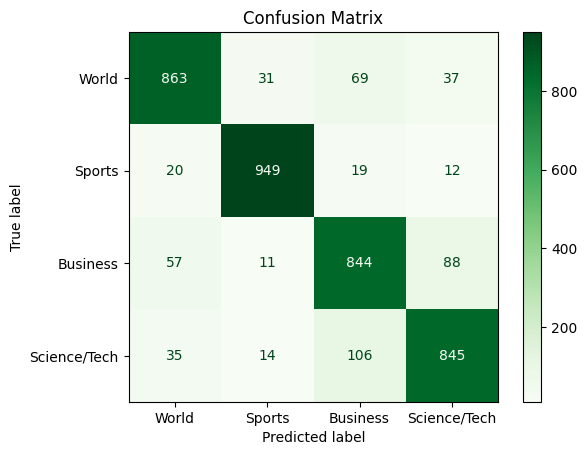

Misclassified Texts:
Predicted: Business, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Business, Actual: World
Text: ankara turkey hope attract  billion foreign invest   reform design overhaul economi eas countri  entri
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: hayley mick journalist current base vancouv broadcast experi cbc radio  quirk quark report vancouv sun cbc onlin canadian press  ontario vancouv bureau
--------------------------------------------------
Predicted: Business, Actual: World
Text: afp eu transport energi commission loyola de palacio hail accord reach alitalia manag staff major restructur plan aim keep struggl airlin air
--------------------------------------------------
Predicted: Sports, Actual: World
Text: sachin tendulkar almost certain miss thurs

In [48]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_sbert), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_sbert[train_index], train_sbert[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        voting_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = voting_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = voting_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(voting_model, test_sbert, test_y)

### Experiment-4 Applying XGBoost, RandomForest, CatBoost and Voting Classifier to asses the Models on Doc2Vec Embeddings

#### XGBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7292
 Validation F1 Score: 0.7291
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7248
 Validation F1 Score: 0.7244
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7160
 Validation F1 Score: 0.7162
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7188
 Validation F1 Score: 0.7186
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7190
 Validation F1 Score: 0.7185
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7292
 Validation F1 Score: 0.7291
-----

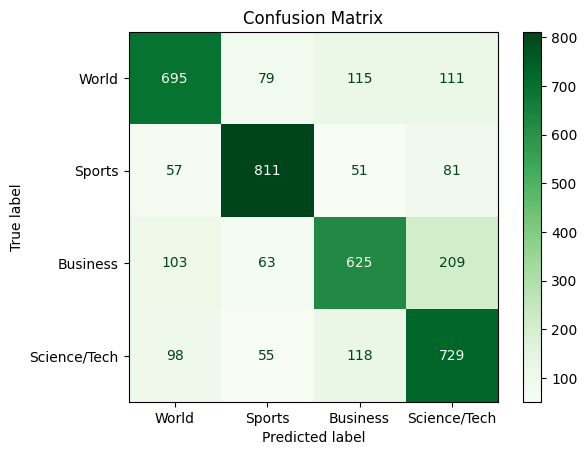

Misclassified Texts:
Predicted: Business, Actual: World
Text: suicid attack deton car bomb near crowd peopl wait appli job iraqi nation guard northern citi kirkuk yesterday kill least  peopl wound  offici said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: near daili attack pipelin pump station push iraq  oil export lowest point nearli year britain  financi time newspap report today
--------------------------------------------------
Predicted: Business, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: us iraqi forc battl milit najaf tuesday iraqi nation guardsmen advanc within  yard holi citi  imam ali shrine compound insurg loyal radic cleric muqtada al sadr hole week
--------------------------------------------------
Predicted: S

In [49]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_doc2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        xgb_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = xgb_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = xgb_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(xgb_model, test_doc2vec, test_y)

#### RandomForest

Iteration: 1
Fold 1/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.6870
 Validation F1 Score: 0.6859
--------------------------------------------------
Fold 2/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.6797
 Validation F1 Score: 0.6785
--------------------------------------------------
Fold 3/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.6627
 Validation F1 Score: 0.6620
--------------------------------------------------
Fold 4/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.6853
 Validation F1 Score: 0.6843
--------------------------------------------------
Fold 5/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.6830
 Validation F1 Score: 0.6820
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.6797
 Validation F1 Score: 0.6787
-----

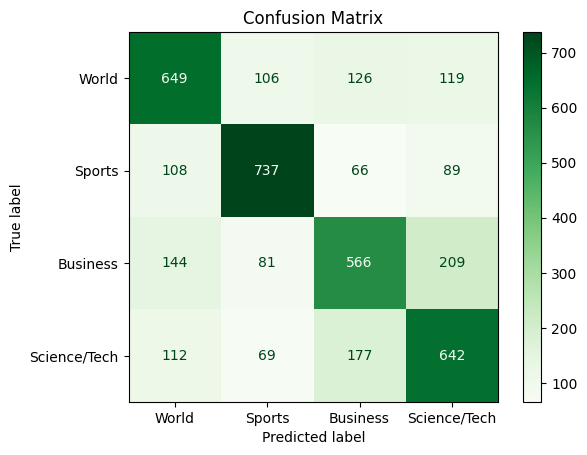

Misclassified Texts:
Predicted: Business, Actual: World
Text: suicid attack deton car bomb near crowd peopl wait appli job iraqi nation guard northern citi kirkuk yesterday kill least  peopl wound  offici said
--------------------------------------------------
Predicted: Business, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Business, Actual: World
Text: shahe china nine peopl confirm dead  remain miss late sunday fire swept five iron ore mine northern china xinhau news agenc said
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: us iraqi forc battl milit najaf tuesday iraqi nation guardsmen advanc within  yard holi citi  imam ali shrine compound insurg loyal radic cleric muqtada al sadr hole week
--------------------------------------------------
Predicted: Sport

In [50]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_doc2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        rf_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = rf_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = rf_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(rf_model, test_doc2vec, test_y)

#### CatBoost

Iteration: 1
Fold 1/5
Training Accuracy: 0.9771
Training F1 Score: 0.9771

Validation Accuracy: 0.7352
 Validation F1 Score: 0.7347
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9764
Training F1 Score: 0.9764

Validation Accuracy: 0.7375
 Validation F1 Score: 0.7367
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9754
Training F1 Score: 0.9754

Validation Accuracy: 0.7250
 Validation F1 Score: 0.7247
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9756
Training F1 Score: 0.9756

Validation Accuracy: 0.7370
 Validation F1 Score: 0.7367
--------------------------------------------------
Fold 5/5
Training Accuracy: 0.9774
Training F1 Score: 0.9774

Validation Accuracy: 0.7388
 Validation F1 Score: 0.7379
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9771
Training F1 Score: 0.9771

Validation Accuracy: 0.7352
 Validation F1 Score: 0.7347
-----

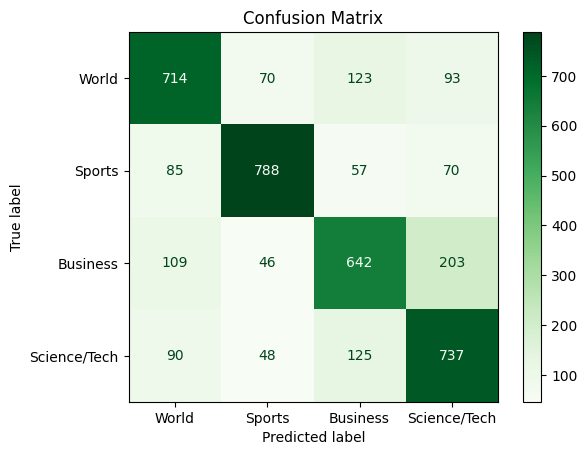

Misclassified Texts:
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------
Predicted: World, Actual: World
Text: reuter larg blast heard central baghdad thursday wit said
--------------------------------------------------


In [51]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_doc2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        catboost_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = catboost_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = catboost_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(catboost_model, test_doc2vec, test_y)

#### Voting Classifier

Iteration: 1
Fold 1/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7418
 Validation F1 Score: 0.7412
--------------------------------------------------
Fold 2/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7438
 Validation F1 Score: 0.7431
--------------------------------------------------
Fold 3/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7232
 Validation F1 Score: 0.7231
--------------------------------------------------
Fold 4/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7378
 Validation F1 Score: 0.7376
--------------------------------------------------
Fold 5/5
Training Accuracy: 1.0000
Training F1 Score: 1.0000

Validation Accuracy: 0.7398
 Validation F1 Score: 0.7388
--------------------------------------------------
Iteration: 2
Fold 1/5
Training Accuracy: 0.9999
Training F1 Score: 0.9999

Validation Accuracy: 0.7430
 Validation F1 Score: 0.7426
-----

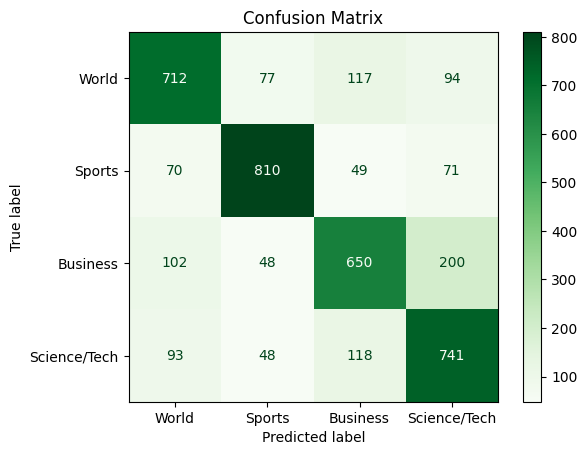

Misclassified Texts:
Predicted: Business, Actual: World
Text: suicid attack deton car bomb near crowd peopl wait appli job iraqi nation guard northern citi kirkuk yesterday kill least  peopl wound  offici said
--------------------------------------------------
Predicted: Business, Actual: World
Text: reuter govern warplan helicopt gunship pound rebel held town northern ivori coast second day friday fuel fear slide war world top cocoa grower
--------------------------------------------------
Predicted: Science/Tech, Actual: World
Text: us iraqi forc battl milit najaf tuesday iraqi nation guardsmen advanc within  yard holi citi  imam ali shrine compound insurg loyal radic cleric muqtada al sadr hole week
--------------------------------------------------
Predicted: Sports, Actual: World
Text: presid bush democrat challeng john f kerri lung final two week  presidenti campaign monday feud feverishli iraq war fight terrorist
--------------------------------------------------
Predicted: Spor

In [52]:
for iter in range(1, 4):
    # Perform K-fold cross-validation
    print(f"Iteration: {iter}")
    for fold, (train_index, val_index) in enumerate(kf.split(train_doc2vec), 1):
        print(f"Fold {fold}/5")
        
        X_train, X_val = train_doc2vec[train_index], train_doc2vec[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
        
        # Train the model using KFold
        voting_model.fit(X_train, y_train)
        
        
        # Evaluate on training set
        train_predictions = voting_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions, average='weighted')
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Training F1 Score: {train_f1:.4f}")
        print()
        # Evaluate on validation set
        val_predictions = voting_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='weighted')
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print("-"*50)
        
print("Evaluating the model on Test Set")   
# After training with K-fold, make predictions on the test set
evaluate_model(voting_model, test_doc2vec, test_y)